In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
print(os.listdir('data'))

ID_Data_test = pd.read_csv('data/ID_Data_test.csv')
ID_Data_train = pd.read_csv('data/ID_Data_train.csv')
ID_Time_train = pd.read_csv('data/ID_Time_train.csv')
sample_sub_coachs = pd.read_csv('data/sample_sub_coachs.csv')
sample_submission = pd.read_csv('data/sample_sub_kaggle.csv')

ID_Data_train = ID_Data_train.sort_values(['id_race', 'id'])

['ID_Data_test.csv', 'ID_Data_train.csv', 'ID_Time_train.csv', 'sample_sub_coachs.csv', 'sample_sub_kaggle.csv']


In [3]:
def calc_diff_angle(data):
    data.loc[:, 'Diff_angle'] = np.abs(data.loc[:, 'direction_vent'] - data.loc[:, 'cap'])
    return data

def calc_cos(data):
    ''' Feature qui s'est révélée la plus importante'''
    data.loc[:, 'cos_angle'] = np.cos((data.loc[:, 'direction_vent'] - data.loc[:, 'cap'])/180 * np.pi)
    return data

def distance(lat1, lng1, lat2, lng2):
    return np.sqrt((lat1 - lat2) ** 2 + (lng1 - lng2) ** 2) 

def distance_angle(lat1, lng1, lat2, lng2, cos_angle, frac=1.5):
    return np.sqrt((lat1 - lat2) ** 2 + (lng1 - lng2) ** 2) * (frac + cos_angle)

ID_Data_train = calc_cos(ID_Data_train)

In [4]:
def calc_diff_angle(data):
    data.loc[:, 'Diff_angle'] = np.abs(data.loc[:, 'direction_vent'] - data.loc[:, 'cap'])
    return data


def creer_features(input_data, time_id):
    """
    input_data : df comprenant les courses des bateaux (séries temporelles des variables considérées)
    time_id : df lié à input_data qui comprend l'ID, le temps, la course, et le rang 
    """
    X_model = pd.DataFrame()
    IDs = time_id['id'].values
    data = input_data.copy()

    for i in tqdm_notebook(IDs): 
        data_id = data[data['id']==i]
        data_id = calc_diff_angle(data_id)
        X_model.loc[i, 'lat_mean'] = data_id['latitude'].mean()
        X_model.loc[i, 'long_std'] = data_id['longitude'].std()
       
    X_model = X_model.fillna(0)
    return X_model


def ecart_classement(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))


def rmse(y, y_pred):
    return np.sqrt(np.mean(np.square(y - y_pred)))


def calc_rank_from_time(data_pred, id_time_train): 
    """ 
    Calcul le rang à partir d'un fichier de prédiction de temps 
    Il faut que la prédiction soit un dataframe avec en indice les id bateau hash, en colonne le temps prédit
    et une autre colonne avec la course.
    Cela permet de reconstruire le classement à partir des données prédites et des données présentes 
    dans le jeu d'entrainement
    """
    IDs = data_pred['id'].tolist()
    id_time_all = pd.concat([data_pred, id_time_train], axis=0)
    id_time_all['Rank'] = id_time_all.groupby('id_race')['temps'].rank(ascending=True)
    data_pred_rank = id_time_all[id_time_all['id'].isin(IDs)]
    return data_pred_rank 


def score_innovation_cup(sub_true, sub_pred):
    """
    Il faut fournir une soumission sous format dataframe avec en index les id_bateau_hash, 
    une première colonne Time, et une seconde colonne rang, celle prédite par l'algo
    Il est conseillé d'inclure la course en colonne également mais ce n'est pas obligatoire
    """
    true_time, true_rank = sub_true['temps'], sub_true['rang']
    pred_time, pred_rank = sub_pred['temps'], sub_pred['rang']
    
    score = ecart_classement(true_rank, pred_rank) + (rmse(true_time, pred_time) / np.sqrt(np.mean(true_time)))
    return score

# A bit of EDA

### Let's visualize the trajectory of some boats to try to understand a bit better the data

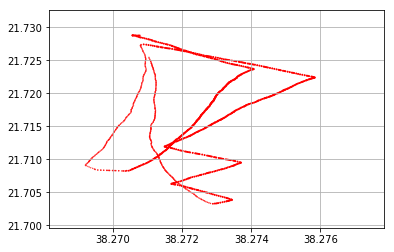

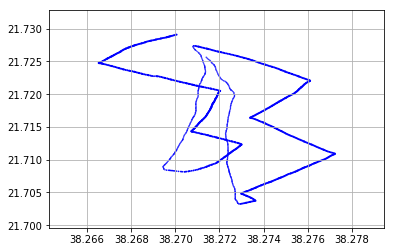

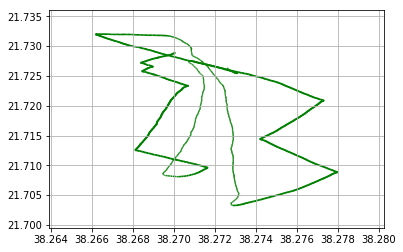

In [5]:
for color, boat in zip(['r', 'b', 'g'], ['56b4154daf1f84f7078b375715a60552',
                                         'eb94a51ccdf5f765ec8192a922289a97',
                                         'fc2131af90bc20c898089f0ffcd10c3b']):
    trajectoire = ID_Data_train.loc[(ID_Data_train['id_race'] == 'R1') & (ID_Data_train['id'] == boat), ['latitude', 'longitude']].values
    weights = ID_Data_train.loc[(ID_Data_train['id_race'] == 'R1') & (ID_Data_train['id'] == boat), 'cos_angle'].values + 1.2
    plt.scatter(trajectoire[:, 0], trajectoire[:, 1], color=color, s=weights/2)
    plt.grid()

    plt.show()

### Let's visualize the cos angle of the boats during the race

We can see the are 2 distincts states: one with cos near 1 and one near minus 1. A key takeaway from this visualisation is that we can see that boats finishing first have low variance for each state (i.e. when cos is near 1, it's not varying a lot).
On the contrary, boats finishing last have some hesitations, the variance is large

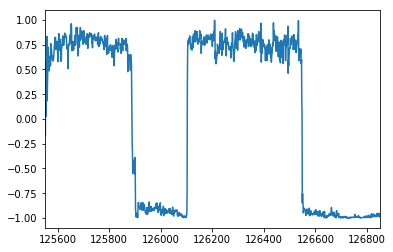

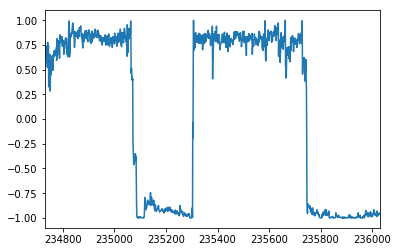

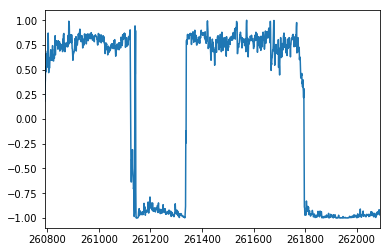

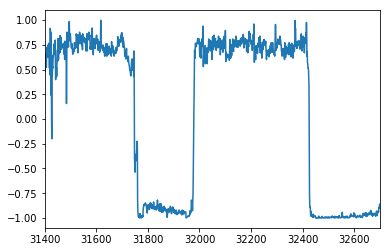

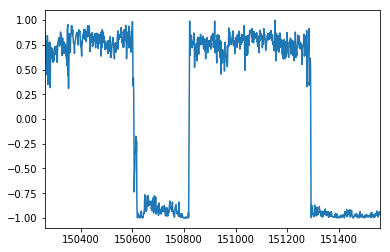

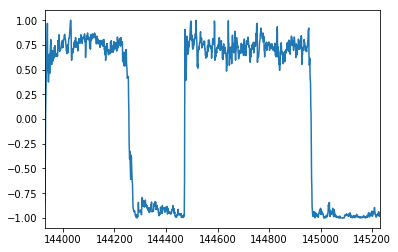

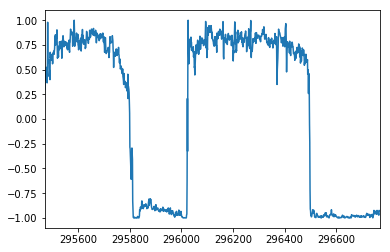

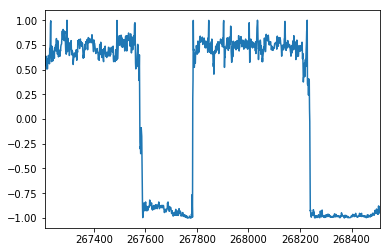

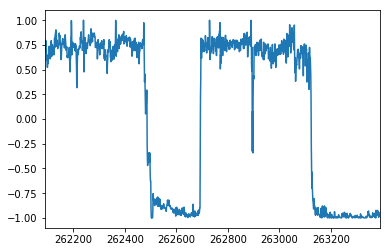

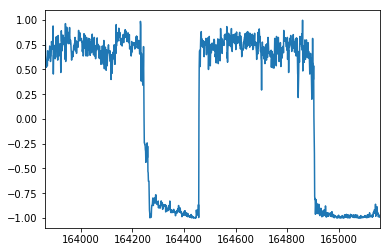

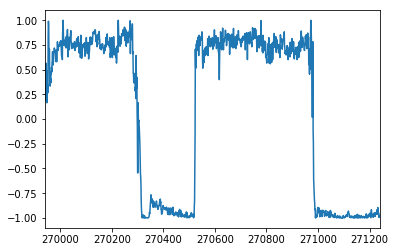

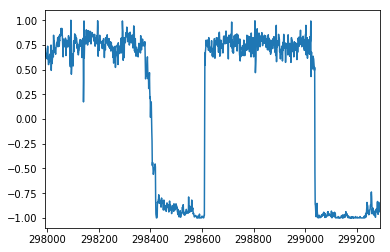

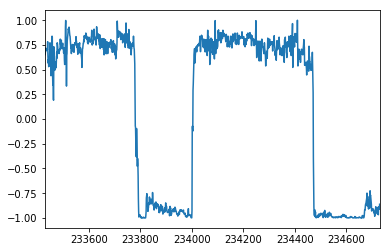

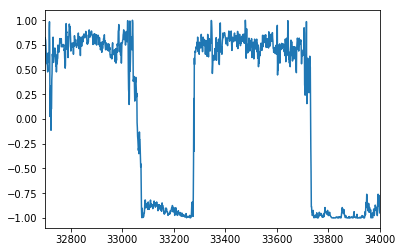

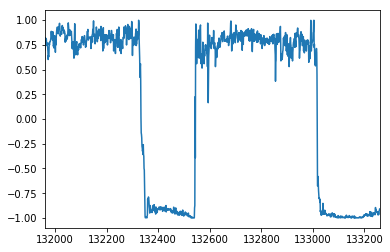

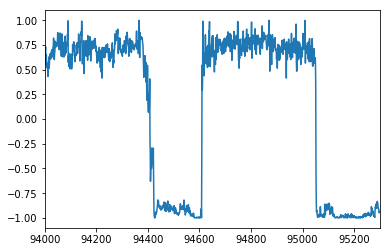

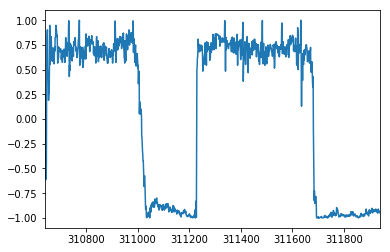

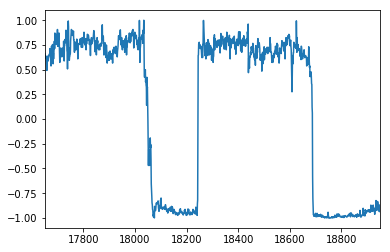

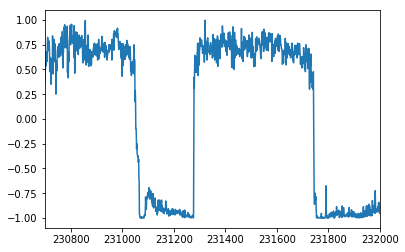

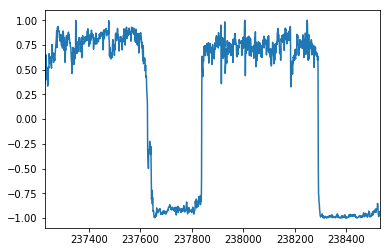

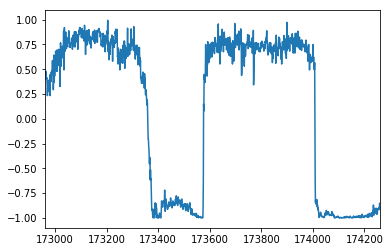

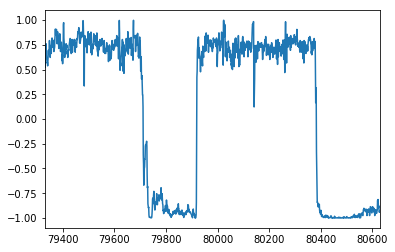

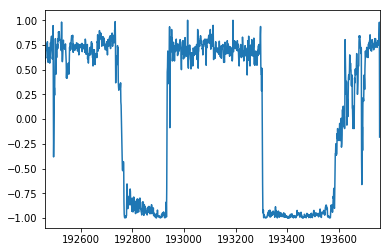

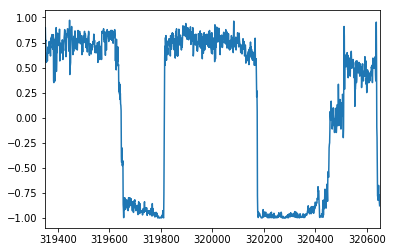

In [6]:
for boat in ID_Time_train[ID_Time_train['id_race'] == 'R1'].sort_values('temps')['id']:
    ID_Data_train.loc[ID_Data_train['id'] == boat, 'cos_angle'].plot()
    plt.show()

In [7]:
ID_Data_train['lat_off1'] = [0] + list(ID_Data_train['latitude'].values[:-1])
ID_Data_train['lng_off1'] = [0] + list(ID_Data_train['longitude'].values[:-1])

In [8]:
distance = ID_Data_train[['latitude', 'longitude', 'lat_off1', 'lng_off1']].apply(lambda row: distance(row[0], row[1], row[2], row[3]), axis=1)
ID_Data_train['distance'] = distance

In [9]:
total = 0
for _, gb in ID_Data_train.groupby(['id_race', 'id']):
    ID_Data_train.iloc[total, -1] = 0
    total += gb.shape[0]

#### Some other dirty visualisation

In [10]:
for boat in ['56b4154daf1f84f7078b375715a60552',
             'eb94a51ccdf5f765ec8192a922289a97',
             'fc2131af90bc20c898089f0ffcd10c3b']:
    print('\n', boat)
    print('fast')
    fast = ID_Data_train.loc[ID_Data_train['id'] == boat, 'cos_angle'].apply(lambda x: x > 0.5).values
    print(round(fast.mean(), 3))
    fast_points = ID_Data_train.loc[fast, 'cos_angle']
    print(round(fast_points.mean(), 3))
    print(round(fast_points.std(), 3))
    print(round(1000 * ID_Data_train.loc[fast, 'distance'].sum()))

    print('mid')
    mid = ID_Data_train.loc[ID_Data_train['id'] == boat, 'cos_angle'].apply(lambda x: -0.5 < x < 0.5).values
    print(round(mid.mean(), 3))
    mid_points = ID_Data_train.loc[mid, 'cos_angle']
    print(round(mid_points.mean(), 3))
    print(round(mid_points.std(), 3))
    print(round(1000 * ID_Data_train.loc[mid, 'distance'].sum()))
    
    
    print('slow')
    slow = ID_Data_train.loc[ID_Data_train['id'] == boat, 'cos_angle'].apply(lambda x: x < -0.5).values
    print(round(slow.mean(), 3))
    slow_points = ID_Data_train.loc[slow, 'cos_angle']
    print(round(slow_points.mean(), 3))
    print(round(slow_points.std(), 3))
    print(round(1000 * ID_Data_train.loc[slow, 'distance'].sum()))


 56b4154daf1f84f7078b375715a60552
fast
0.589
0.646
0.383
55.0
mid
0.021
0.675
0.349
2.0
slow
0.39
-0.64
0.619
45.0

 eb94a51ccdf5f765ec8192a922289a97
fast
0.627
0.709
0.191
57.0
mid
0.031
-0.272
0.603
3.0
slow
0.342
-0.851
0.395
42.0

 fc2131af90bc20c898089f0ffcd10c3b
fast
0.535
0.284
0.752
54.0
mid
0.122
-0.661
0.661
13.0
slow
0.343
0.216
0.736
35.0
